# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run the code block below, first)

In [1]:
""" These first few lines below import the IPython definitions and methods that we will use. 
Please Refer to ipython_api.py for the implementation """
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from ipython_api import IPythonAPI as iapi
from parameter_definitions import *
%matplotlib inline

# The lines below define the available telescopes, bands and modes that may be chosen.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, 
                   Bands.Mid1, Bands.Mid2, Bands.Mid5A, Bands.Mid5B, 
                   Bands.Sur1)
available_modes = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.SlowTrans)
verbose_display = False
BL_dep_time_av = False  #baseline dependent time averaging

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Using default values, we can compare telescopes side-by-side

Dump time:  0.75*s
USING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = Min(1.2*s, 47978.9320229823*m*s/Bmax,bin)
Tdump_backward = Min(60.0*s, 47978.9320229823*N_facet*m*s/Bmax,bin)
Evaluating Nfacets = 1
Tsnap has been optimized as : 114.348989. (Cost function = 2.608515)
Evaluating Nfacets = 2
Tsnap has been optimized as : 193.624237. (Cost function = 2.525120)
Evaluating Nfacets = 3
Tsnap has been optimized as : 240.394889. (Cost function = 3.665714)

Expression increasing with number of facets; aborting exploration of Nfacets > 3

2.525120 PetaFLOPS was the lowest FLOP value, found for (Nfacet, Tsnap) = (2, 193.62)
Dump time:  0.6*s
USING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = Min(1.2*s, 47978.9320229823*m*s/Bmax,bin)
Tdump_backward = Min(60.0*s, 47978.9320229823*N_facet*m*s/Bmax,bin)
Evaluating Nfacets = 1
Tsnap has been optimized as : 79.854967. (Cost function = 31.830472)
Evaluating Nfacets = 2
Tsnap has been optimized as : 139.685195. (Cost function = 34.443335)



Telescope,SKA1_Low_rebaselined,SKA1_Low_old,km
Max Baseline,80,100,
Max # channels,65536,256000,
Optimal Number of Facets,2,1,
Optimal Snapshot Time,194,79.9,sec.
Visibility Buffer,23.7,463,PetaBytes
Working (cache) memory,1.47,33.8,TeraBytes
Image side length,74308,208993,pixels
I/O Rate,5.49,26.8,TeraBytes/s
Total Compute Requirement,2.53,31.8,PetaFLOPS
-> Gridding,0.416,13.3,PetaFLOPS


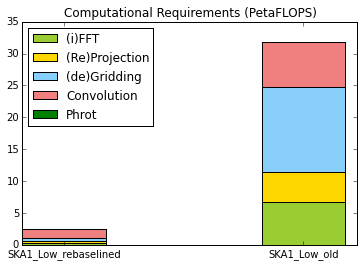

In [2]:
interact_manual(iapi.compare_telescopes_default, 
                Telescope_1=available_teles, Telescope_2=available_teles, Band=available_bands, Mode=available_modes,
                BL_dep_time_av=BL_dep_time_av, verbose=verbose_display);

## We can also interactively play with parameters (via sliders)

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [3]:
interact(iapi.evaluate_telescope_manual, max_baseline=(10,200), Nf_max = (1,256000,1), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         Telescope=available_teles, Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, 
         verbose=verbose_display);

Max Baseline,70 km
Max # of channels,128000
Telescope,SKA1_Low_rebaselined
Band,Low
Mode,Continuum
Tsnap,900.6 sec
Nfacet,5


Dump time:  0.75*s
NOT IMPLEMENTING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = 0.75*s
Tdump_backward = Min(60.0*s, 0.75*N_facet*s)


Visibility Buffer,0.777 PetaBytes
Working (cache) memory,1.26 TeraBytes
Image side length,46814 pixels
I/O Rate,4.95 TeraBytes/s
Total Compute Requirement,4.39 PetaFLOPS
-> Gridding,0.17 PetaFLOPS
-> FFT,0.00952 PetaFLOPS
-> Projection,0.0076 PetaFLOPS
-> Convolution,4.18 PetaFLOPS
-> Phase Rotation,0.0187 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

#### This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required
#### In this example, *Tsnap and Nfacet* are *automatically* chosen so as to minimize the value of Rflop

Max Baseline,59 km
Max # of channels,128000
Telescope,SKA1_Low_rebaselined
Band,Low
Mode,Continuum


Dump time:  0.75*s
USING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = Min(1.2*s, 26654.9622349902*m*s/Bmax,bin)
Tdump_backward = Min(60.0*s, 26654.9622349902*N_facet*m*s/Bmax,bin)
Evaluating Nfacets = 1
Tsnap has been optimized as : 31.713540. (Cost function = 0.818407)
Evaluating Nfacets = 2
Tsnap has been optimized as : 53.360595. (Cost function = 0.615363)
Evaluating Nfacets = 3
Tsnap has been optimized as : 68.560166. (Cost function = 0.746625)

Expression increasing with number of facets; aborting exploration of Nfacets > 3

0.615363 PetaFLOPS was the lowest FLOP value, found for (Nfacet, Tsnap) = (2, 53.36)


Optimal Number of Facets,2
Optimal Snapshot Time,53.4 sec.
Visibility Buffer,0.646 PetaBytes
Working (cache) memory,0.0916 TeraBytes
Image side length,98644 pixels
I/O Rate,0.658 TeraBytes/s
Total Compute Requirement,0.615 PetaFLOPS
-> Gridding,0.0746 PetaFLOPS
-> FFT,0.124 PetaFLOPS
-> Projection,0.0912 PetaFLOPS
-> Convolution,0.323 PetaFLOPS


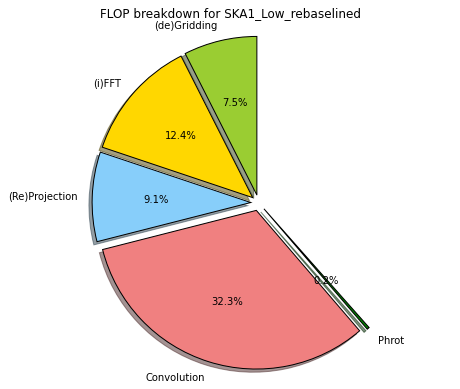

In [4]:
interact_manual(iapi.evaluate_telescope_optimized, max_baseline=(10,200), Nf_max = (1,256000,1), Telescope=available_teles, 
         Band=available_bands, Mode=available_modes, BL_dep_time_av=BL_dep_time_av, verbose=verbose_display);